对于一般的有监督学习，都存在输入$\boldsymbol{x}=(x_1,\dots,x_n)^T$和输出$\boldsymbol{y}$之间的概率联系（否则就是不可预测的, 后面也就不必讨论了），也就是大概率意义上存在一个**预测函数**$y=F^*(\boldsymbol{x})$。 如果给定**损失函数**$L(y,F(\boldsymbol{x}))$，那么这个学习问题的数学表达式就是：

$$
F^*(\boldsymbol{x}) =  \underset{F(\boldsymbol{x})}{\rm{argmin}} \ \mathbb{E}_{(\boldsymbol{x},y)} L(y,F(\boldsymbol{x}))
$$

如果给定一个初始预测函数$F_0(\boldsymbol{x})$，那么可以**梯度下降法**标准迭代公式得到一个更精确的预测函数：

$$
F_k(\boldsymbol{x}) = F_{k-1}(\boldsymbol{x}) + \gamma_k r_k(\boldsymbol{x}), \quad r_k(\boldsymbol{x})  = -\left[\dfrac{\partial L(y,F(\boldsymbol{x}))}{\partial F(\boldsymbol{x})}\right]_{F(\boldsymbol{x}) = F_{k-1} \ (\boldsymbol{x})}, \quad k=1,\dots 
$$

我们用**梯度下降法**求解一个泛函问题，本质上隐含一个假设，那就是预测函数$F(\boldsymbol{x})$满足**可加性**：

$$
F(\boldsymbol{x}) =  \sum_{k=0}^M \gamma_k h_k(\boldsymbol{x})
$$

其实这就是一个**集成模型**， 而其中$h_k(\boldsymbol{x})$就是一个**基学习器**。我们进一步假设**基学习器**相互之间的差别仅仅是参数不一样，于是上式可改写成：

$$
F(\boldsymbol{x}) = \sum_{k=0}^M \gamma_k h(\boldsymbol{x};\boldsymbol{a}_k)
$$

所谓**梯度提升算法**, 本质上就是用**梯度下降法**求解上面的最优化问题。 

于是我们目标就变成：如果给定一个**数据集**$\left\{ (\boldsymbol{x}_i, y_i) \right\}_1^m$，在**梯度下降法**的每一步学习出参数$\gamma_k$和$\boldsymbol{a}_k$，这是一个局部优化问题：

$$
(\gamma_k, \boldsymbol{x}_k) = \underset{\gamma, \ \boldsymbol{x}}{\rm{argmin}} \ \sum_{i=1}^m {L\left( y_i, F_{k-1}(\boldsymbol{x}_i) + \gamma \ h(\boldsymbol{x}_i; \boldsymbol{a}) \right)} 
$$

对比**梯度下降法**迭代公式，我们首先可以用$h(\boldsymbol{x}; \boldsymbol{a})$来拟合$r_k(\boldsymbol{x})$ ：

$$
\boldsymbol{a}_k = \underset{\boldsymbol{a}, \ \rho}{\rm{argmin}} \ \sum_{i=1}^m \left[r_k(\boldsymbol{x}) - \rho \ h(\boldsymbol{x}_i; \boldsymbol{a}) \right]^2 
$$

一旦有了最优拟合参数$\boldsymbol{a}_k$，我们可以进一步选择一个最优$\gamma_k$ ：

$$
\gamma_k = \underset{\gamma}{\rm{argmin}} \ \sum_{i=1}^m {L\left( y_i, F_{k-1}(\boldsymbol{x}_i) + \gamma \ h(\boldsymbol{x}_i; \boldsymbol{a}_k) \right)} 
$$

当然要启动前面这个迭代流程，还需要一个初值常函数：

$$
F_0(\boldsymbol{x}) =  \underset{\gamma}{\rm{argmin}} \ \sum_{i=1}^m {L(y_i,\gamma)} 
$$

至此， **梯度提升算法**的算法流程已经完整了。

### 梯度提升算法的一个简化版本

首先，我们选择单样本损失函数形如：

$$L(y,F(\boldsymbol{x})) = \dfrac{1}{2} (y - F(\boldsymbol{x}))^2$$

进而可计算出(这是一个**残差**形式)：

$$
r_k(\boldsymbol{x})  = y - F_{k-1}(\boldsymbol{x})
$$

然后，选择选择**二元决策树**作为**基学习器**$h(\boldsymbol{x};\boldsymbol{a})$，这一步我们可以用软件包构建一个**基模型**, 参数$\boldsymbol{a}$就已经隐含在已经训练好的**基模型**中。

最后我们选择0常值函数作为初始预测函数$F_0(\boldsymbol{x})=0$，选择固定步长$\gamma_k = \gamma$。

至此，我们获得一个简化版本的梯度提升算法流程。


下面的代码就是这个梯度提升算法简化版本的实现。

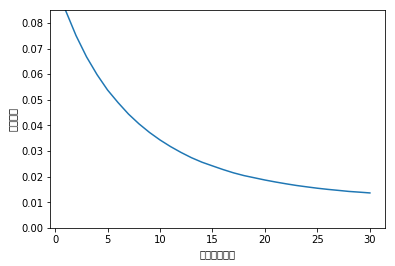

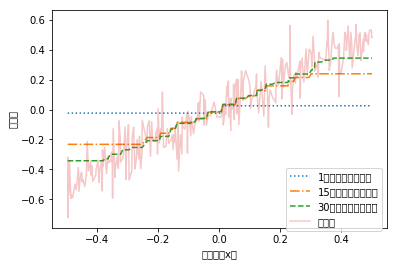

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

'''
    产生玩具数据集
'''
m = 1001
# 产生一组含标准正态随机扰动数据集
x = 1.0*np.arange(m)/(m-1)-0.5
np.random.seed(1)
y = x+np.random.normal(scale=0.1,size=m)

'''
    采样30%的数据作为测试集
'''
msample = int(m*0.3)
idx = list(range(m));np.random.shuffle(idx)
idxtest = idx[:msample];idxtest.sort()
idxtrain = list(set(idx)-set(idxtest));idxtrain.sort()
xtrain = x[idxtrain].reshape((m-msample,1));ytrain = y[idxtrain]
xtest = x[idxtest].reshape((msample,1));ytest = y[idxtest]

'''
    在训练集上生成一系列模型
'''

# 生成的最大模型数
numtreemax = 30
# 决策树深度
treedepth = 1

# 收集模型及其对应的预测
modellist = []
predlist = []

gamma = 0.1
# 残差初始化：初始化为样本值，即初始化预测值全为0
# 所谓残差，就是样本值与预测值的偏差
residuals = ytrain.copy()

for itree in range(numtreemax):
    # 在整个训练数据进行二元决策树训练，然后拟合残差值（初始拟合样本值）
    modellist.append(DecisionTreeRegressor(max_depth=treedepth))
    modellist[-1].fit(xtrain,residuals)
    
    # 样本内预测， 然后以gamma步长，更新残差
    latestinsampleprediction = modellist[-1].predict(xtrain)
    residuals = residuals - gamma*latestinsampleprediction
    
    # 样本外预测并收集预测值
    latestoutsampleprediction = modellist[-1].predict(xtest)
    predlist.append(list(latestoutsampleprediction))
'''
    给定头n个模型 n=1,...，numTreesMax
    依次计算n个模型的平均预测值 
    依次计算n个模型的均方误差 
'''

allPredictions = gamma * np.cumsum(predlist,axis=0) 
mse = ((ytest - allPredictions)**2).sum(axis=1) / len(ytest)

'''
    绘制或输出计算结果 
'''

# 绘制均方误差和模型数之间的关系
nModels = [i + 1 for i in range(numtreemax)]
plt.plot(nModels,mse)
plt.axis('tight')
plt.xlabel(u'所用模型数目')
plt.ylabel(u'均方误差')
plt.ylim((0.0, max(mse)))
plt.show()

# 绘制原始数据及3组特定模型产生的预测值
plotList = [0, 14, 29]
lineType = [':', '-.', '--']
plt.figure()
for i in range(len(plotList)):
    iPlot = plotList[i]
    textLegend = str(iPlot+1) +  u'决策树时的预测值'
    plt.plot(xtest, allPredictions[iPlot], label = textLegend, linestyle = lineType[i])
plt.plot(xtest, ytest, label='标签值', alpha=0.25)
plt.axis('tight')
plt.legend(bbox_to_anchor=(1,0.3))
plt.xlabel(u'测试输入x值')
plt.ylabel(u'预测值')
plt.show()

我们可以通过反复调整代码中的决策树深度numTreesMax和步长gamma这两个参数，重新运行上面的代码来观察其效果。

图一表明，随着决策树的增加，均方误差会持续下降。

图二表明，随着决策树的增加，预测能更好地逼近正确答案。

随着决策树深度的加深，不但能够改善均方误差，而且能够更好地逼近正确答案。（调整参数，重新运行上面的代码来观察）

随着步长的增加，均方误差曲线会在尾部缓慢增大，这不好，所以我们应该选择一个合适的步长，确保均方误差曲线最小值靠近右端。

随着步长的增加，预测曲线会有更多的突起。

### 多变量问题的梯度提升法

下面依然以红酒口感数据集为例, 和前面的代码很类似, 关键是观察其运行结果。

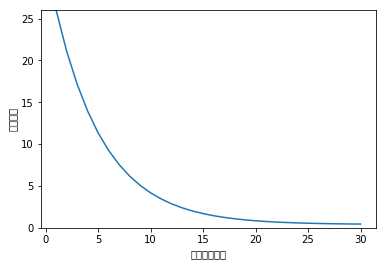

In [4]:
# 获取红酒数据集
target_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(target_url, header=0, sep=";")
df.columns = ['非挥发性酸','挥发性酸','柠檬酸', '残留糖分', '氯化物', '游离二氧化硫','总二氧化硫', '密度', 
              'PH值', '亚硝酸盐', '酒精含量', '品质']

xData = df.values[:,:-1]; yData = df.values[:,-1] 
m, n = xData.shape

'''
    采样30%的数据作为测试集
'''

mSample = int(m * 0.30); 
idx = list(range(m)); np.random.shuffle(idx)
idxTest = idx[:mSample]; idxTest.sort()
idxTrain = list(set(idx) - set(idxTest)); idxTrain.sort()
xTrain = xData[idxTrain,:]; yTrain = yData[idxTrain]
xTest = xData[idxTest,:]; yTest = yData[idxTest]

'''
    在训练集上生成一系列模型
'''

# 生成的最大模型数
numTreesMax = 30
# 决策树深度
treeDepth = 5

# 收集模型及其对应的预测
modelList = []
predList = []

gamma = 0.1

# 残差初始化：初始化为样本值，即初始化预测值全为0
# 所谓残差，就是样本值与预测值的偏差
residuals = yTrain.copy()

for iTrees in range(numTreesMax):
    # 在整个训练数据进行二元决策树训练，然后拟合残差值（初始拟合样本值）
    modelList.append(DecisionTreeRegressor(max_depth=treeDepth))
    modelList[-1].fit(xTrain, residuals)

    # 样本内预测， 然后以gamma步长，更新残差
    latestInSamplePrediction = modelList[-1].predict(xTrain)    
    residuals = residuals - gamma * latestInSamplePrediction
    
    # 样本外预测并收集预测值
    latestOutSamplePrediction = modelList[-1].predict(xTest)
    predList.append(list(latestOutSamplePrediction))

'''
    给定头n个模型 n=1,...，numTreesMax
    依次计算n个模型的平均预测值 
    依次计算n个模型的均方误差 
'''

allPredictions = gamma * np.cumsum(predList,axis=0) 
mse = ((yTest - allPredictions)**2).sum(axis=1) / len(yTest)

'''
    绘制或输出计算结果 
'''

# 绘制均方误差和模型数之间的关系
nModels = [i + 1 for i in range(numTreesMax)]
plt.plot(nModels,mse)
plt.axis('tight')
plt.xlabel(u'所用模型数目')
plt.ylabel(u'均方误差')
plt.ylim((0.0, max(mse)))
plt.show()